# Importing base libraries

In [76]:
# Preparing and importing everything we need in this lab
from scipy.io import arff
import pandas as pd
import itertools

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Preparing data

## Loading ARFF 

In [77]:
# Data
ARFF_FILE = 'diabetes.arff' # file is in the same folder, as jupyter is ran, and ipynb file

arff_data = arff.loadarff(ARFF_FILE)
df = pd.DataFrame(arff_data[0])
df.head(5) # first 5 entities

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


## Converting 

In [78]:
target = df['class']
data = df.drop(columns=['class'])
target = target.astype('str')

In [79]:
# plot confusion matrix

In [80]:
from sklearn import dummy, metrics

baseline = dummy.DummyClassifier(strategy='most_frequent')
baseline.fit(data, target)
base_predictions = baseline.predict(data)


## Helper for plot

In [81]:
def plot_confusion_matrix(matrix, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    pyplot.imshow(matrix, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
        horizontalalignment="center",
        color="white" if matrix[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()
    pyplot.clf()
    pyplot.cla()
    pyplot.close()

# Baseline

Accuracy = 0.651
                    precision    recall  f1-score   support

b'tested_negative'       0.65      1.00      0.79       500
b'tested_positive'       0.00      0.00      0.00       268

         micro avg       0.65      0.65      0.65       768
         macro avg       0.33      0.50      0.39       768
      weighted avg       0.42      0.65      0.51       768

Confusion matrix, without normalization


/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


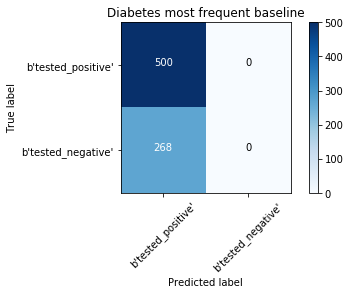

In [82]:
baseline = dummy.DummyClassifier(strategy='most_frequent')
baseline.fit(data, target)
base_predictions = baseline.predict(data)

accuracy = metrics.accuracy_score(target, base_predictions)
print ("Accuracy = {:.3f}".format(accuracy))

print(metrics.classification_report(target, base_predictions))

plot_confusion_matrix(metrics.confusion_matrix(target, base_predictions), 
                      classes=target.unique(), 
                      title='Diabetes most frequent baseline')

# Training


In [83]:
from sklearn import model_selection as ms

train_data, test_data, train_labels, test_labels = ms.train_test_split(data, target, test_size=0.33)
print("Training data size: {}".format(len(train_data)))
print("Testing data size: {}".format(len(test_data)))

Training data size: 514
Testing data size: 254


In [ ]:
from sklearn import tree

diabetes_split_tree_model = tree.DecisionTreeClassifier(presort=True,       # shows better results
                                                        max_features='auto',
                                                        min_samples_leaf=5, # prevent overlearning
                                                        random_state=0)     # make sure random is controlled
diabetes_split_tree_model.fit(train_data, train_labels)
print('Model fitted')

Model fitted


Depth: 10


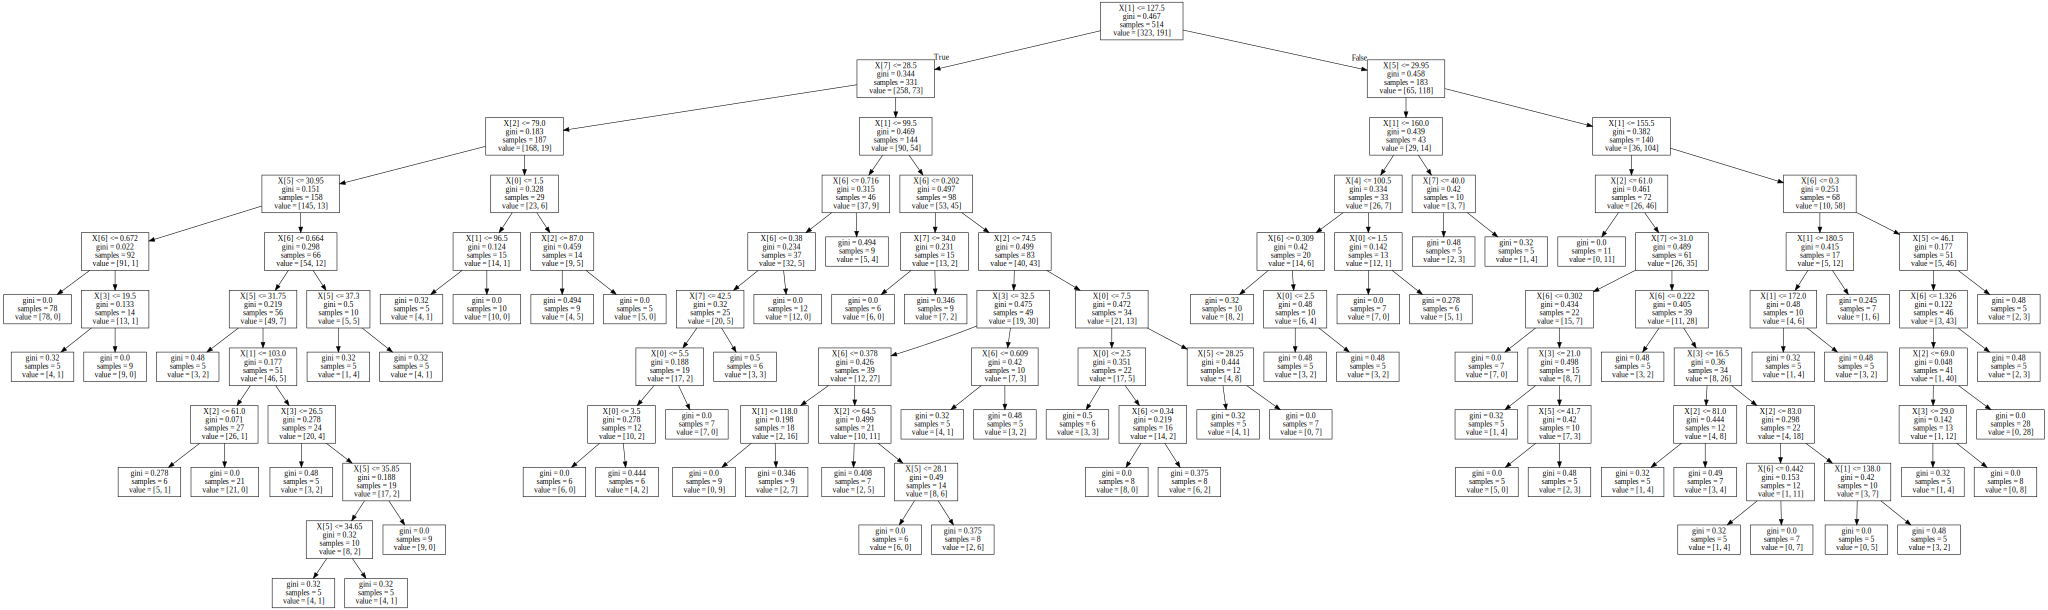

In [ ]:
import graphviz # needs isntalling graphviz

def print_tree(_tree):
    print("Depth: {}".format(_tree.tree_.max_depth))
    dot_data = tree.export_graphviz(_tree, out_file=None)
    graph = graphviz.Source(dot_data) 
    return graph

print_tree(diabetes_split_tree_model)

# Predicting on test data

In [ ]:
def print_classification_report(labels, predictions, title='Diabetes testing train split tree'):
    "Prints the matrix and accuracy of predictions"
    accuracy = metrics.accuracy_score(labels, predictions)

    print ("Accuracy = {:.3f}".format(accuracy))

    print(metrics.classification_report(labels, predictions))

    plot_confusion_matrix(metrics.confusion_matrix(labels, predictions), 
                          classes=labels.unique(), 
                          title=title)

Accuracy = 0.748
                    precision    recall  f1-score   support

b'tested_negative'       0.83      0.81      0.82       177
b'tested_positive'       0.58      0.61      0.59        77

         micro avg       0.75      0.75      0.75       254
         macro avg       0.70      0.71      0.71       254
      weighted avg       0.75      0.75      0.75       254

Confusion matrix, without normalization


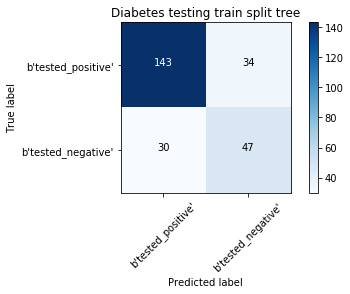

In [ ]:
split_tree_predictions = diabetes_split_tree_model.predict(test_data)

print_classification_report(test_labels,  split_tree_predictions)

# Cross validation

## Scoring

In [ ]:
diabetes_cv_tree_model = tree.DecisionTreeClassifier(random_state=1, 
                                                     min_samples_leaf=2)

folds = 5

acc_scorer = metrics.make_scorer(metrics.accuracy_score)
recall_scorer = metrics.make_scorer(metrics.recall_score, average='weighted')
prec_scorer = metrics.make_scorer(metrics.precision_score, average='weighted')
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

scoring = {'accuracy': acc_scorer, 
 'recall': recall_scorer, 
 'precision' : prec_scorer,
 'f1': f1_scorer}

# More information:
# https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics

cv_tree_model_scores = ms.cross_validate(diabetes_cv_tree_model,
                                         data,
                                         target,
                                         scoring=scoring,
                                         cv=folds,
                                         return_train_score=True)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Evaluation results for {} folds'.format(folds))

for (k,v) in cv_tree_model_scores.items():
 print(('{}: {}').format(k,v))


Evaluation results for 5 folds
fit_time: [ 0.014  0.017  0.013  0.012  0.012]
score_time: [ 0.031  0.027  0.021  0.020  0.021]
test_accuracy: [ 0.675  0.636  0.682  0.791  0.712]
train_accuracy: [ 0.945  0.954  0.956  0.943  0.963]
test_recall: [ 0.675  0.636  0.682  0.791  0.712]
train_recall: [ 0.945  0.954  0.956  0.943  0.963]
test_precision: [ 0.660  0.646  0.680  0.788  0.706]
train_precision: [ 0.946  0.956  0.957  0.946  0.963]
test_f1: [ 0.662  0.640  0.681  0.782  0.708]
train_f1: [ 0.944  0.954  0.956  0.942  0.962]


## Cross validtion predictions

### Decision Tree Classifier

Accuracy = 0.721
                    precision    recall  f1-score   support

b'tested_negative'       0.79      0.78      0.78       500
b'tested_positive'       0.60      0.61      0.61       268

         micro avg       0.72      0.72      0.72       768
         macro avg       0.69      0.70      0.69       768
      weighted avg       0.72      0.72      0.72       768

Confusion matrix, without normalization


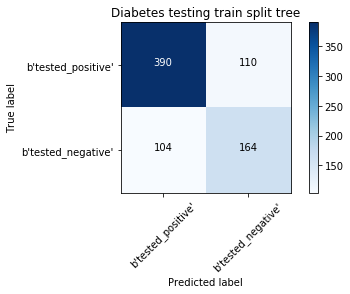

In [ ]:
diabetes_cv_predict_tree_model = tree.DecisionTreeClassifier(presort=True,       # shows better results
                                                             max_features='auto',
                                                             min_samples_leaf=5, # prevent overlearning
                                                             random_state=0)

cv_tree_predictions = ms.cross_val_predict(diabetes_cv_predict_tree_model, 
                                           data, 
                                           target,
                                           cv=folds)

print_classification_report(target,  cv_tree_predictions)

# Preparing 
```
Do-it-all-at-once function for SOLID purpose
Common definition for all classifiers
Common dict for test and train data
```

In [ ]:
# Do-it-all-at-once function for SOLID purpose
def CV_report(classifier, hyperparameters, data_params):
    print(classifier)
    # Parsing class name of a classifier
    module, class_name = classifier.rsplit('.', 1)
    __import__(module) # importing is important so module is visible in sys.modules
    classifier_class = getattr(sys.modules[module], class_name)
    print(class_name)
    print(classifier_class.__name__)
    
    # Parsing data
    train_data = data_params['train']['data']
    train_labels = data_params['train']['labels']
    test_data = data_params['test']['data']
    test_labels = data_params['test']['labels']
    
    # Creating and griding classifier
    classifier = classifier_class()
    grid = ms.GridSearchCV(
        classifier,
        hyperparameters,
        refit=True,
        scoring=f1_scorer,
        iid=True,
        cv=6 # TODO: change or pass
    )
    
    # Fitting
    model = grid.fit(train_data, train_labels)
    print("Best parameters:")
    print(model.best_params_)
    print()
    
    # Predicting
    predictions = grid.predict(test_data)
        
    # Plotting
    print_classification_report(test_labels, predictions, title=classifier_class.__name__)

#### Data

In [ ]:
# Common definitio for all classifiers
# Looks like: (module, Classifier) : [{hyper parameters}]
#import sklearn.tree
#import sklearn.svm
#import sklearn.linear_model

CLASSIFIERS = {
    # DecisionTree
    'sklearn.tree.DecisionTreeClassifier': [{
        'presort':[True, False],       
        'max_features':['auto', 1, 2, 3],
        'min_samples_leaf':[2, 3, 4, 5, 6],
        'random_state':[0, None]
    }],
    # SVC
    'sklearn.svm.SVC': [
        {
            'kernel': ['rbf'],
            'gamma': [1e-3],
            'C': [1, 10],
        },
        {
            'kernel': ['linear'], 
            'gamma': [1e-4],
            'C': [1, 10]
        }
    ],
    # LogisticRegression
    'sklearn.linear_model.LogisticRegressionCV': [{
        'max_iter':[1000],
        'penalty':['l1'],
        'solver':['saga', 'liblinear'], # only acceptable for for l1
        'scoring':['roc_auc'],
    }, {
        'scoring':['roc_auc'],
        'penalty':['l2'],
        'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    }],
    'sklearn.naive_bayes.GaussianNB': [{
        'var_smoothing': [1e-3, 1e-7, 1e-9],
    }],
    'sklearn.ensemble.RandomForestClassifier': [{
        'n_estimators':[50, 100, 120],
        'criterion':['entropy', 'gini'],
        'max_depth':[None, 8, 13],
        'min_samples_split':[1,3],
        'min_samples_leaf':[1,3],
        'max_features':['auto', 'log2', 'sqrt'],
        'bootstrap':[True, False],
    }],
    'sklearn.ensemble.AdaBoostClassifier': [{
        
    }]
}

# Common dict for test and train data
DATA = {
    'train': {
        'data': train_data,
        'labels': train_labels,
    },
    'test': {
        'data': test_data,
        'labels': test_labels,
    },
    'all': {
        'data': data,
    }
}


# Classifying and cross validating
#### Going to take a long time

**********************************************************************
Using SVC...
sklearn.tree.DecisionTreeClassifier
DecisionTreeClassifier
DecisionTreeClassifier
Best parameters:
{'max_features': 'auto', 'min_samples_leaf': 6, 'presort': True, 'random_state': 0}

Accuracy = 0.748
                    precision    recall  f1-score   support

b'tested_negative'       0.85      0.78      0.81       177
b'tested_positive'       0.57      0.68      0.62        77

         micro avg       0.75      0.75      0.75       254
         macro avg       0.71      0.73      0.72       254
      weighted avg       0.76      0.75      0.75       254

Confusion matrix, without normalization


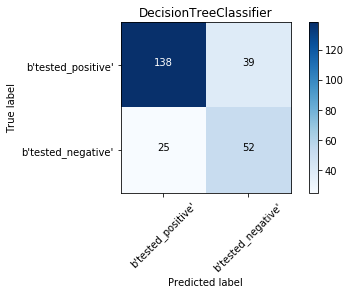

**********************************************************************
**********************************************************************
Using SVC...
sklearn.svm.SVC
SVC
SVC


In [ ]:

for (classifier, hyperparams) in CLASSIFIERS.items():
    print('*' * 70)
    print("Using {}...".format(classifier_class_str))
    # Each classificator gets initialized and passed to CV Grid
    # Then a common report is created and matrix is vizualized    
    CV_report(classifier, 
              hyperparams, 
              DATA)
    print('*' * 70)

# Testing and debugging

In [ ]:
# Testing any classifier
classifier = 'sklearn.ensemble.RandomForestClassifier'
__import__(classifier.rsplit('.', 1)[0])
class_ = getattr(sys.modules[classifier.rsplit('.',1)[0]], classifier[1])
CV_report(class_, CLASSIFIERS[classifier], DATA)